In [1]:
import torch, pickle, time, os, random, shutil
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from pysr import pysr, PySRRegressor
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score
import dataframe_image as dfi

import PIL
from PIL import Image

from sympy.parsing.sympy_parser import parse_expr
import sympy
from sympy import sympify, lambdify
import matplotlib as mpl

from scipy.special import erf as scerf

pd.set_option('max_colwidth', 800)

module_dictionary = {'log': np.log, 'abs': np.abs}
exec('''
def log_abs(x):
    return log(abs(x))
''', module_dictionary)
log_abs = module_dictionary['log_abs']

module_dictionary = {'log10': np.log10, 'abs': np.abs}
exec('''
def log10_abs(x):
    return log10(abs(x))
''', module_dictionary)
log10_abs = module_dictionary['log10_abs']

module_dictionary = {'power': np.power}
exec('''
def cube(x):
    return power(x,3)
''', module_dictionary)
cube = module_dictionary['cube']

module_dictionary = {'power': np.power}
exec('''
def square(x):
    return power(x,2)
''', module_dictionary)
square = module_dictionary['square']

module_dictionary = {'sqrt': np.sqrt, 'abs': np.abs}
exec('''
def sqrt_abs(x):
    return sqrt(abs(x))
''', module_dictionary)
sqrt_abs = module_dictionary['sqrt_abs']

module_dictionary = {'max': np.max}
exec('''
def relu(x):
    return max(x,0)
''', module_dictionary)
relu = module_dictionary['relu']

module_dictionary = {'scerf': scerf}
exec('''
def erf(x):
    return scerf(x)
''', module_dictionary)
erf = module_dictionary['erf']


exec('''
def neg(x):
    return -x
''', module_dictionary)
neg = module_dictionary['neg']

mappings ={'log_abs':log_abs, 
           'log10_abs':log10_abs,
           'sqrt_abs':sqrt_abs,
          'square':square,
          'cube':cube,
          'relu':relu,
          'neg':neg,
          'erf':erf}


class CallableEquation:
    """Simple wrapper for numpy lambda functions built with sympy"""

    def __init__(self, sympy_symbols, eqn, selection=None, variable_names=None):
        self._sympy = eqn
        self._sympy_symbols = sympy_symbols
        self._selection = selection
        self._variable_names = variable_names
        self._lambda = lambdify(sympy_symbols, eqn, ['numpy', mappings])
#         self._lambda = lambdify(sympy_symbols, eqn)
        

    def __repr__(self):
        return f"PySRFunction(X=>{self._sympy})"

    def __call__(self, X):
        expected_shape = (X.shape[0],)
        if isinstance(X, pd.DataFrame):
            # Lambda function takes as argument:
            return self._lambda(**{k: X[k].values for k in X.columns}) * np.ones(
                expected_shape
            )
        elif self._selection is not None:
            return self._lambda(*X[:, self._selection].T) * np.ones(expected_shape)
        return self._lambda(*X.T) * np.ones(expected_shape)

In [2]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot1(ys, pred, streq, var):
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [5, 3, 3]})
    targ = tcols[target]
    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.1, 0.67
    bottom, height = 0.0, 0.75
    bottom_h = bottom +height
    left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.01, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

    # start with a rectangular Figure
    ax0  = ax[0]
    ax0.set_axis_off()
    # axCbar = plt.axes(rect_Cbar)
    axHist = ax0.inset_axes(rect_scatter)
    axHistx = ax0.inset_axes(rect_histx)
    axHisty = ax0.inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.005
    n_contour=4
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white', linestyles='dashed', linewidths=1.2)
    axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
    if i==0:
        axHist.set(xlabel=f'SAM {targ}',ylabel=f'GNN {targ}', xticks=[5,6,7,8,9,10,11])
    else:
        axHist.set(xlabel=f'SAM {targ}',ylabel=f'Abundance matched {targ}', xticks=[5,6,7,8,9,10,11])
    if i==0:
        axHist.legend(loc='lower right', fontsize=14)


    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'

    #calculate metrics
    pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
    r2=r2_score(ys,pred)
    rho = np.corrcoef(ys,pred)[0,1]
    print(np.std(ys-pred),np.mean(ys-pred), pct, r2, rho)

    xt=0.03
    yt=0.85
    dy=0.07
    font = {'weight': 'normal',
        'size': 15}

    axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys, 0.1)
    pred_kde = stats.gaussian_kde(pred, 0.1)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
    axHistx.legend(loc='upper left',fontsize=12)
    axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.125), fontsize=12)

    axHistx.set(title=f'PySR {targ} relationship')

#         axHistx.set_xlim(axHist.get_xlim())
#         axHisty.set_ylim(axHist.get_ylim())

    divider = make_axes_locatable(axHisty)
    cax = divider.append_axes("right", size="5%", pad=0.0)
    divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

    # Plot vertical colorbar
    plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

    tot = np.hstack([pred, ys])
    r = np.nanpercentile(tot, [l, 100-l])
    r += np.array([-0.5,0.5])

    ax[1].hist(pred, bins=50, alpha=0.3, range=r, label='pred');
    ax[1].hist(ys, bins=50, alpha=0.3, range=r, label='true');
    ax[1].set(title = f'Distributions of pred and true', xlabel=r'log($M_*$)')
    ax[1].legend()

    ##
    res = ys - pred

    ax[2].hist(res, bins=50, alpha=0.3, range=np.nanpercentile(res, [l*10,100-l*10]));
    ax[2].set(title = f'Residuals, bias = {np.nanmean(res):.3f}, std = {np.nanstd(res):.3f}', xlabel = 'true-pred')
    fig.suptitle([streq, var], y=1.05);
    
    return fig

In [3]:
def mh_ms(ys, pred, Mhf, ks = [0], l=0.01, cy = 'k', cpred = 'g', nbins=25, fill = 0, ms=1, afill = 0.3, aplot = 0.7):
    
    fig, ax = plt.subplots(1, 3, figsize=(17,5), sharex=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
#     ax = ax.transpose()
    cy1, cpred1 = 'b', 'r'
#     for k in ks:
    # edges=np.percentile(Mhf[Mhf>10.5], np.linspace(0,100,nbins))
    global inner, outer, inpred, outpred, Mhin, Mhout
    edges=np.linspace(10, max(Mhf),nbins)
    centers=(edges[:-1]+edges[1:])/2
    sigM=[]
    ysigs, predsigs = [], []
    yb, predb = [], []
    pillai_gnn = []
    pillai_ys = []
    pred1684, ys1684 = [], []
    inner, outer = [], []
    inpred, outpred = [], []

    Mhin, Mhout = [], []
    Mhinpred, Mhoutpred = [], [] 

    for i in range(len(edges)-1):
        if i==0:
            mask=edges[i+1]>=Mhf
        else:
            mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
#             mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)

        ysigs.append(np.std(ys[mask]))
        predsigs.append(np.std(pred[mask]))
        sigM.append(np.std(pred[mask]-ys[mask]))
        yb.append(np.median(ys[mask]))
        predb.append(np.median(pred[mask]))
        pillai_gnn.append((np.percentile(pred[mask], 84)-np.percentile(pred[mask], 16))/2)
        pillai_ys.append((np.percentile(ys[mask], 84)-np.percentile(ys[mask], 16))/2)
        pred1684.append(np.percentile(pred[mask], [16,84]))
        ys1684.append(np.percentile(ys[mask], [16,84]))

    edge2=np.linspace(10, max(Mhf),nbins)

    for i in range(len(edge2)-1):
        if i==0:
            mask=edge2[i+1]>=Mhf
        else:
            mask=np.logical_and(edge2[i]<=Mhf,edge2[i+1]>=Mhf)
        lims = [0.5,99.5]
        yslim = np.percentile(ys[mask], lims)
        ymaskin = np.logical_and(ys[mask]>yslim[0], ys[mask]<yslim[1])
        inner.append(ys[mask][ymaskin])
        outer.append(ys[mask][~ymaskin])
        Mhin.append(np.array(Mhf)[mask][ymaskin])
        Mhout.append(np.array(Mhf)[mask][~ymaskin])

        predlim = np.percentile(pred[mask], lims)
        predmaskin = np.logical_and(pred[mask]>predlim[0], pred[mask]<predlim[1])
        inpred.append(pred[mask][predmaskin])
        outpred.append(pred[mask][~predmaskin])
        Mhinpred.append(np.array(Mhf)[mask][predmaskin])
        Mhoutpred.append(np.array(Mhf)[mask][~predmaskin])


    inner = np.hstack(inner)
    outer = np.hstack(outer)
    inpred = np.hstack(inpred)
    outpred = np.hstack(outpred)
    Mhin = np.hstack(Mhin)
    Mhout = np.hstack(Mhout)
    Mhinpred = np.hstack(Mhinpred)
    Mhoutpred = np.hstack(Mhoutpred)


    sigM=np.array(sigM)
    ysigs, predsigs = np.array(ysigs), np.array(predsigs)
    yb, predb = np.array(yb), np.array(predb)
    ys1684, pred1684 = np.vstack(ys1684), np.vstack(pred1684)

#         ax[k][0].plot(Mhf, ys[:,k], 'bo', markersize=ms, alpha=aplot, label = f'SAM {cols_t[k]}')
    if fill:
        ax[2].plot(centers, yb, f'{cy}-.', label =f'Median PySR {tcols[target]}')
        ax[1].plot(centers, yb, f'{cy}-.', linewidth=4, label =f'Median SAM {tcols[target]}')


#         ax[k][0].plot(Mhf, pred[:,k], 'ro', markersize=ms, alpha=aplot, label = f'GNN {cols_t[k]}')
    if fill:
        ax[2].plot(centers, predb, f'{cpred}-', label =f'Median PySR {tcols[target]}')
        ax[0].plot(centers, predb, f'{cpred}-', linewidth=4, label =f'Median PySR {tcols[target]}')



    if fill:
        ax[2].fill_between(centers, ys1684[:,0], ys1684[:,1], color=f'{cy1}', alpha=afill, label = f'16th/84th percentile SAM {tcols[target]}')
        ax[2].fill_between(centers, pred1684[:,0], pred1684[:,1], color=f'{cpred1}', alpha=afill, label = f'16th/84th percentile GNN {tcols[target]}')

    cmap = mpl.cm.viridis

    ax[1].plot(Mhout, outer, 'bo', markersize=ms*3, alpha=aplot, label = f'SAM {tcols[target]} outliers')
    ax[1].hist2d(Mhin, inner, bins=100,\
         norm=mpl.colors.LogNorm(), cmap=cmap, label = f'SAM {tcols[target]} outliers')
#         ax[1].annotate(f'SAM {cols_t[k]}', xy = (0.07,0.9), xycoords = 'axes fraction')

    ax[0].plot(Mhoutpred, outpred, 'ro', markersize=ms*3, alpha=aplot, label = f'PySR {tcols[target]} outliers')
    ax[0].hist2d(Mhinpred, inpred, bins=100,norm=mpl.colors.LogNorm(), cmap=cmap)
#         ax[0].annotate(f'GNN {cols_t[k]}', xy = (0.07,0.9), xycoords = 'axes fraction')



#         ax[k][2].hist2d(Mhf, ys[:,k], bins=100,\
#              norm=mpl.colors.LogNorm(), cmap=cmap)

#         ax[k][3].hist2d(Mhf, pred[:,k], bins=100,norm=mpl.colors.LogNorm(), cmap=cmap)


    a = ax[0]
    a.set(ylim=np.percentile(np.hstack([pred, ys]), [l,100-l])+np.array([-0.3,0.3]), xlim=(10,13.5))
    a.set(title = f'PySR {tcols[target]}')
    a.legend(fontsize = 12, loc = 'lower right')
    a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
    xlabel = r'$M_{halo}$', ylabel = tcols[target])
    
    a = ax[1]
    a.set(ylim=np.percentile(np.hstack([pred, ys]), [l,100-l])+np.array([-0.3,0.3]), xlim=(10,13.5))
    a.set(title = f'SAM {tcols[target]}')
    a.legend(fontsize = 12, loc = 'lower right')
    a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
    xlabel = r'$M_{halo}$')
    
    a = ax[2]
    a.set(ylim=np.percentile(np.hstack([pred, ys]), [l,100-l])+np.array([-0.2,0.2]), xlim=(10,13.5))
    a.set(title = f'{tcols[target]} median/dispersion')
    a.legend(fontsize = 12, loc = 'lower right')
    
    a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
    xlabel = r'$M_{halo}$')
        
        
    return fig, [yb, predb], [ys1684, pred1684]

def visual_dist(ys, pred, streq):
    
    l=0.01
    tot = np.hstack([pred, ys])
    r = np.nanpercentile(tot, [l, 100-l])
    r += np.array([-0.5,0.5])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

    ax[0].hist(pred, bins=50, alpha=0.3, range=r, label='pred');
    ax[0].hist(ys, bins=50, alpha=0.3, range=r, label='true');
    ax[0].set(title = f'Distributions of pred and true', xlabel=r'log($M_*$)')
    ax[0].legend()

    ##
    res = ys - pred

    ax[1].hist(res, bins=50, alpha=0.3, range=np.nanpercentile(res, [l*10,100-l*10]));
    ax[1].set(title = f'Residuals, bias = {np.nanmean(res):.3f}, std = {np.nanstd(res):.3f}', xlabel = 'true-pred')
    fig.suptitle([streq, eqndf['vars'][idx]], y=1.05);
    return fig

In [4]:
def med_spread(ys, pred, Mhf, nbins = 25):
    edges=np.linspace(10, max(Mhf),nbins)
    centers=(edges[:-1]+edges[1:])/2
    sigM=[]
    ysigs, predsigs = [], []
    yb, predb = [], []
    pillai_gnn = []
    pillai_ys = []
    pred1684, ys1684 = [], []

    for i in range(len(edges)-1):
        if i==0:
            mask=edges[i+1]>=Mhf
        else:
            mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
#             mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)

        ysigs.append(np.std(ys[mask]))
        predsigs.append(np.std(pred[mask]))
        sigM.append(np.std(pred[mask]-ys[mask]))
        yb.append(np.median(ys[mask]))
        predb.append(np.median(pred[mask]))
        pillai_gnn.append((np.percentile(pred[mask], 84)-np.percentile(pred[mask], 16))/2)
        pillai_ys.append((np.percentile(ys[mask], 84)-np.percentile(ys[mask], 16))/2)
        pred1684.append(np.percentile(pred[mask], [16,84]))
        ys1684.append(np.percentile(ys[mask], [16,84]))


    sigM=np.array(sigM)
    ysigs, predsigs = np.array(ysigs), np.array(predsigs)
    yb, predb = np.array(yb), np.array(predb)
    ys1684, pred1684 = np.vstack(ys1684), np.vstack(pred1684)
    return [yb, predb], [ys1684, pred1684]

In [5]:
cols0=np.array(['num_prog(0)', 'Mvir(1)', 'Rvir(2)', 'rs(3)', 'vrms(4)',
       'scale_of_last_MM(5)', 'vmax(6)', 'Jx(7)', 'Jy(8)',
       'Jz(9)', 'Tidal_Force((13)', 'Rs_Klypin(14)', 'Mvir_all(15)',
       'M200b(16)', 'M200c(17)', 'M500c(18)', 'M2500c(19)', 'Xoff(20)',
       'Voff(21)', 'Spin_Bullock(22)', 'b_to_a(23)', 'c_to_a(24)',
       'A[x](25)', 'A[y](26)', 'A[z](27)', 'b_to_a((28)',
       'c_to_a((29)', 'A[x]((30)', 'A[y]((31)', 'A[z]((32)',
       'T/|U|(33)', 'M_pe_Behroozi(34)', 'M_pe_Diemer(35)',
       'Halfmass_Radius(36)', 'cNFW(37)'])
cols = []

for i, c in enumerate(cols0):
    if c[-3]=='(':
        co = c[:-3]
    if c[-4]=='(':
        co = c[:-4]
    if co[-1]=='(':
        co=co[:-1]
    cols.append(co+f'({i})')
cols = np.array(cols)

tcols = np.array(['Mstar', 'Mcold', 'Zcold', 'SFR', 'SFR100', 'Mbh'])

In [6]:
def get_vars(streq):
    vs = []
    for i, s in enumerate(streq):
        if s=='x' and streq[i+1].isdigit() and not streq[i+2].isdigit():
            vs.append(int(streq[i+1]))
        if s=='x' and streq[i+1].isdigit() and streq[i+2].isdigit():
            vs.append(int(streq[i+1:i+3]))
    return np.unique(np.sort(np.array(vs)))
        
# vs = np.array(vs)

def get_eq(folder, fname):
    
#     streq = row["Equation"]
    all_outputs = [pd.read_csv(osp.join(folder,fname), sep = "|")]
    all_outputs[-1].rename(
        columns={
            "Complexity": "complexity",
            "MSE": "loss",
            "Equation": "equation",
        },
        inplace=True    
    )
    ret_outputs = []
    vss = []
    for output in all_outputs:
        scores = []
        lastMSE = None
        lastComplexity = 0
        sympy_format = []
        lambda_format = []

        sympy_symbols = [sympy.Symbol("x%d" % i) for i in range(n_feat)]

        for _, eqn_row in output.iterrows():
            eqnstr = eqn_row["equation"]
            eqn = sympify(eqnstr)
            sympy_format.append(eqn)

            # Numpy:
            lambda_format.append(
                CallableEquation(
                    sympy_symbols, eqn))
#             print(eqnstr)
            vs = get_vars(eqnstr)
            vss.append(vs)
#         output['vars'] = cols[vs]
    return all_outputs, sympy_format, lambda_format, np.array(vss)

In [7]:
date = '300522'
folder = f'eqs_{date}'
target = 0
scale = 0
rf = os.listdir(folder)
files = []
for f in rf:
    if tcols[target] in f and 'bkup' not in f:
        files.append(f)
files

['lfbirc_Mstar.csv',
 'besbts_Mstar.csv',
 'jnqwhq_Mstar.csv',
 'pxnwxg_Mstar.csv',
 'uqfqke_Mstar.csv',
 'rxmmqd_Mstar.csv',
 'mmmisd_Mstar.csv',
 'keqfbo_Mstar.csv',
 'zhulni_Mstar.csv',
 'cohyke_Mstar.csv',
 'wovokt_Mstar.csv',
 'llwbed_Mstar.csv',
 'bkhyzu_Mstar.csv',
 'xwikkz_Mstar.csv',
 'yguuxf_Mstar.csv',
 'uksrwn_Mstar.csv',
 'rautrm_Mstar.csv',
 'rdnewh_Mstar.csv',
 'jtblke_Mstar.csv',
 'aysgng_Mstar.csv',
 'fmilmy_Mstar.csv',
 'qdswma_Mstar.csv',
 'abcmuo_Mstar.csv',
 'krvfdw_Mstar.csv']

In [8]:
print('Loading data')
if scale:
    xs = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/standard_raw_final_6t/xs.pkl"), 'rb'))
    ys = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/standard_raw_final_6t/ys.pkl"), 'rb'))
else:
    xs = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/raw_raw_final_6t/xs.pkl"), 'rb'))
    ys = pickle.load(open(osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/raw_raw_final_6t/ys.pkl"), 'rb'))
n_feat = len(xs[0])
n_targ = len(ys[0])
print('Loaded data')

Loading data
Loaded data


In [9]:
f = 4
eqndf, eqns, eqnlam, vs = get_eq(folder, files[f])
eqndf = pd.read_csv(osp.join(folder,files[f]), sep = "|")

/tmp/ipykernel_917/4022296483.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return all_outputs, sympy_format, lambda_format, np.array(vss)


In [10]:
sig, bias, r2, pearson, nnan = [], [], [], [], []
downs, meds, ups, kss = [], [], [], []
names = []
for i, eq in enumerate(eqnlam):
    pred = eq(xs)
    nnan.append(sum(np.isnan(pred)))
    sig.append(np.nanstd(ys[:,target]-pred))
    bias.append(np.nanmean(ys[:,target]-pred))
    if len(vs[i])!=0:
        names.append(cols[vs[i]])
    else:
        names.append('')
    try:
        r2.append(r2_score(ys[:,target], pred))
        pearson.append(np.corrcoef(ys[:,target], pred)[0][1])
    except:       
        r2.append(np.nan)        
        pearson.append(np.nan)  
    biases, spreads = med_spread(ys[:,target], pred, xs[:,1])
    ybias, predbias = biases
    yspread, predspread = spreads
    meds.append(np.std(ybias-predbias))
    down, up = np.std(yspread - predspread, axis=0)
    downs.append(down)
    ups.append(up)
    ks = ks_2samp(ys[:,target], pred).pvalue
    kss.append(np.log10(ks+1e-300))
    
#     med, down, up, ks
        
eqndf['RMSE'] = np.sqrt(eqndf['MSE'])
eqndf['std'] = sig
eqndf['bias'] = bias
eqndf['R2'] = r2
eqndf['pearson'] = pearson
eqndf['nnan'] = nnan
eqndf['nvars'] = [len(name) for name in names]
eqndf['vars'] = names
eqndf['meds'] = meds
eqndf['ups'] = ups
eqndf['downs'] = downs
eqndf['Ks'] = kss

In [11]:
foms = []
for i in range(len(eqndf)):
    row = eqndf.loc[i]
    fom = 2*row['std'] - row['Ks']/500 + row['downs']/5 + row['ups']/5 + row['meds']/5 + 0.2*row['nvars'] + 0.01*row['Complexity']
    foms.append(fom)
#     if fom<0.6:
#             print(i, row['Equation'], fom)
eqndf['fom']=foms    
eqndf.dropna(inplace=True)
eqndf

,Complexity,MSE,Equation,RMSE,std,bias,R2,pearson,nnan,nvars,vars,meds,ups,downs,Ks,fom
0,1,1.885975,-0.25591516,1.373308,0.930138,-0.938699,-1.018493,1.265801e-16,0,0,,1.340099,1.371237,1.283598,-300.000000,3.269264
1,2,1.568936,log10_abs(x0),1.252572,0.857436,-1.253293,-1.665340,5.136887e-01,0,1,[num_prog(0)],0.969024,0.946352,0.992156,-300.000000,3.116378
2,3,0.421828,(x32 + -10.966345),0.649483,0.520546,-0.368583,0.529771,9.032572e-01,0,1,[M_pe_Diemer(32)],0.463075,0.507926,0.379790,-300.000000,2.141251
3,5,0.120758,((x16 + -10.752837) / 0.56761646),0.347503,0.238286,-0.048617,0.931638,9.730110e-01,0,1,[M2500c(16)],0.406926,0.440401,0.361914,-300.000000,1.568420
4,6,0.075109,(erf(x16 + -10.684221) / 0.46599868),0.274060,0.244620,-0.050707,0.927863,9.673890e-01,0,1,[M2500c(16)],0.119260,0.078337,0.225754,-300.000000,1.433910
5,8,0.063031,((erf(x16 + -10.510119) / 0.45616323) - 0.31692895),0.251059,0.207705,0.000876,0.950134,9.748095e-01,0,1,[M2500c(16)],0.111645,0.160113,0.183573,-275.628502,1.337733
6,9,0.061040,(tanh(log_abs(cube(log10_abs(x6) + -0.95727956))) * 2.3960848),0.247062,0.202003,-0.017835,0.952467,9.765073e-01,0,1,[vmax(6)],0.083873,0.123556,0.190138,-300.000000,1.373520
7,10,0.060325,(tanh(log10_abs(square(cube(log10_abs(x6) + -0.95805025)))) * 2.621647),0.245611,0.193380,-0.014637,0.956528,9.784092e-01,0,1,[vmax(6)],0.097920,0.133676,0.187130,-138.878782,1.048262
8,11,0.058254,((tanh(log_abs(cube(log10_abs(x6) + -0.9500564))) * 2.4035459) - x19),0.241359,0.194093,-0.014064,0.956228,9.781611e-01,0,2,"[vmax(6), Spin_Bullock(19)]",0.079484,0.131984,0.179772,-202.184330,1.380803
9,12,0.057974,((tanh(log10_abs(square(cube(log10_abs(x6) + -0.95075345)))) * 2.621647) - x19),0.240777,0.187638,-0.016761,0.958980,9.796112e-01,0,2,"[vmax(6), Spin_Bullock(19)]",0.091362,0.140914,0.172844,-91.364840,1.159029


In [22]:
def combine_images(tmp):
    list_im = ['dfrow1.png', 'dfrow2.png', 'fig1.png', 'fig2.png']
    imgs    = [ Image.open(osp.join(tmp, i)) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[2][1]
    shapes = [i.size for i in imgs]
#     print(min_shape, sorted( [(np.sum(i.size), i.size ) for i in imgs]))
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

    path = f'figs/{tcols[target]}/{files[f][:6]}_eq{idx}.png'
    # save that beautiful picture
#     imgs_comb = Image.fromarray( imgs_comb)
#     imgs_comb.save( 'Trifecta.jpg' )    
    
    imgs_pad = []
    for i, im in enumerate(imgs):
        s = np.asarray(im).shape[1]
        shape = min_shape[0]
        p = (shape-s)//2
        p=abs(p)
        padded_im = np.pad(np.asarray(im), ((0,0),(p, p), (0,0)), 'constant', constant_values=((0, 0), (0, 0), (0,0)))
        imgs_pad.append(Image.fromarray(padded_im))
    # for a vertical stacking it is simple: use vstack
    min_shapes = [(min_shape[0], 100), (min_shape[0], 100), min_shape, min_shape] 
    imgs_comb = np.vstack( [np.asarray( im.resize(min_shapes[i])) for i, im in enumerate(imgs_pad)])
#     imgs_stack = np.copy(img)
    imgs_comb = Image.fromarray( imgs_comb)
    imgs_stack = np.copy(imgs_comb)
    
    imgs_comb.save(path)
    return imgs, imgs_comb, imgs_stack

0.1933795408058197 -0.014636853721326833 0.8239620730921476 0.956528272090298 0.9784092073775977


/tmp/ipykernel_917/2953905900.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/3268910648.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


0.1876376328783525 -0.016760603706834593 0.8287213476940072 0.9589799477488385 0.9796111629143721


/tmp/ipykernel_917/2953905900.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/3268910648.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


0.19461452025588635 -0.008601533505051481 0.8125195618153365 0.9561365357320419 0.9778962230283457


/tmp/ipykernel_917/2953905900.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/3268910648.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


0.19453269817136742 -0.006815736405554792 0.8138635735984535 0.9562051625008928 0.9779198000415622


/tmp/ipykernel_917/2953905900.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/3268910648.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


0.20770509626293618 0.0008757586933228689 0.8115069501979195 0.9501337245894288 0.9748094843788644


/tmp/ipykernel_917/2953905900.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/2953905900.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_917/3268910648.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )


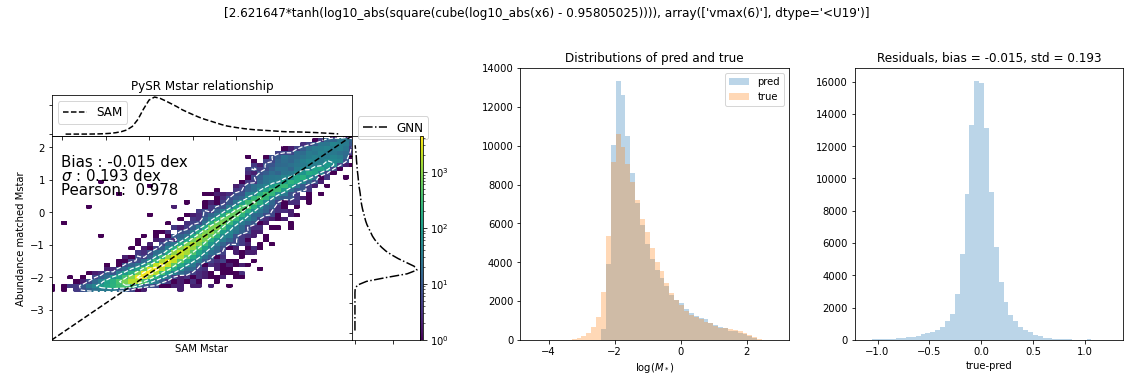

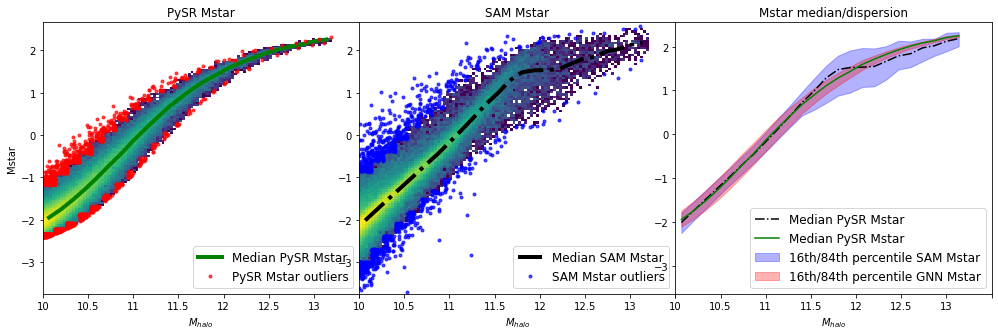

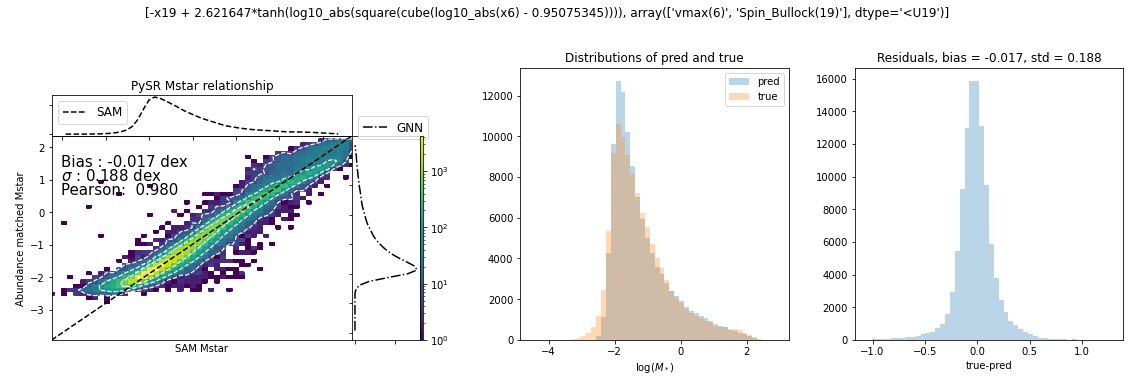

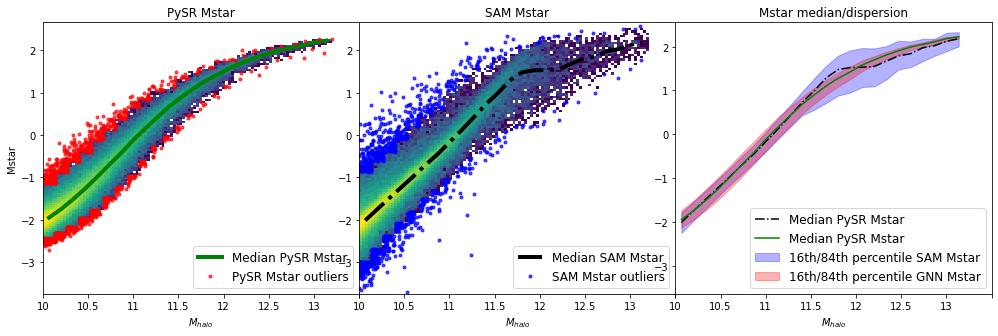

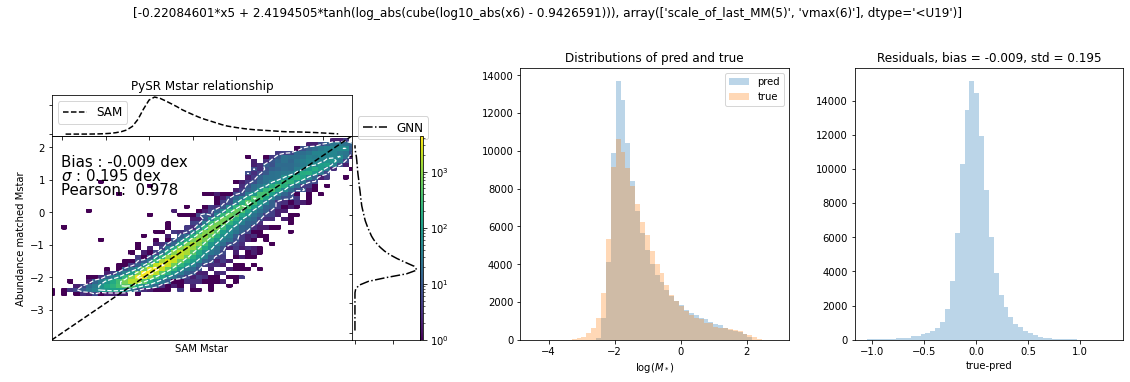

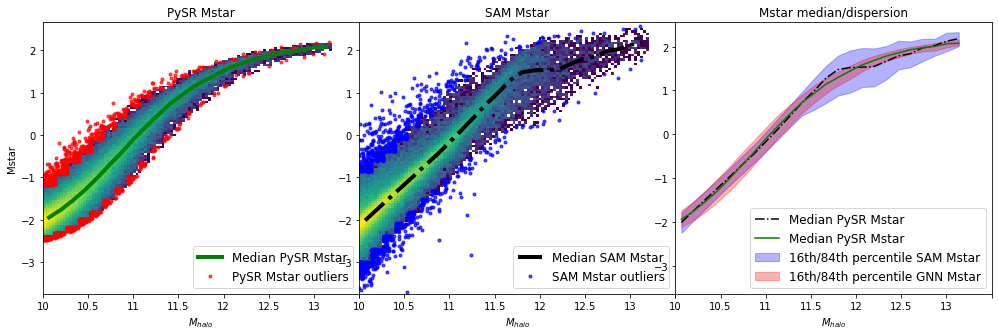

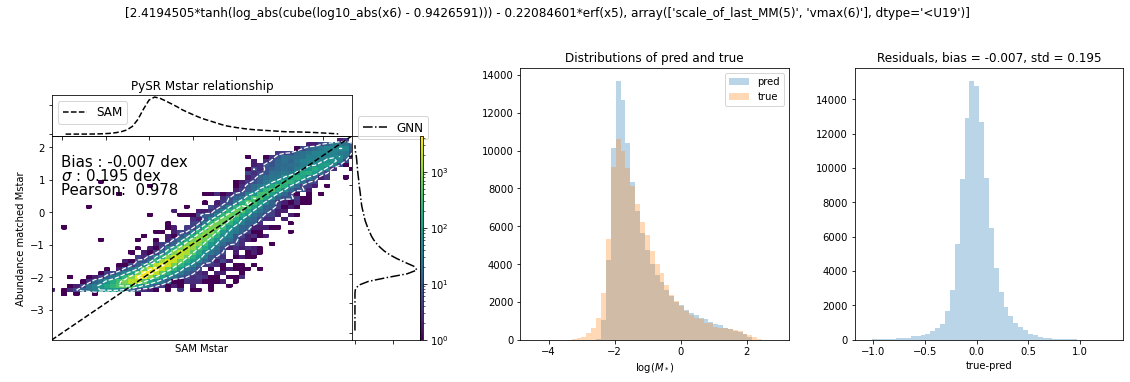

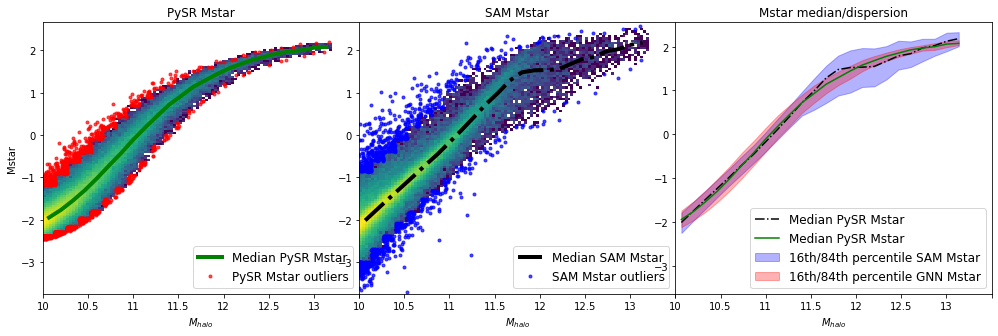

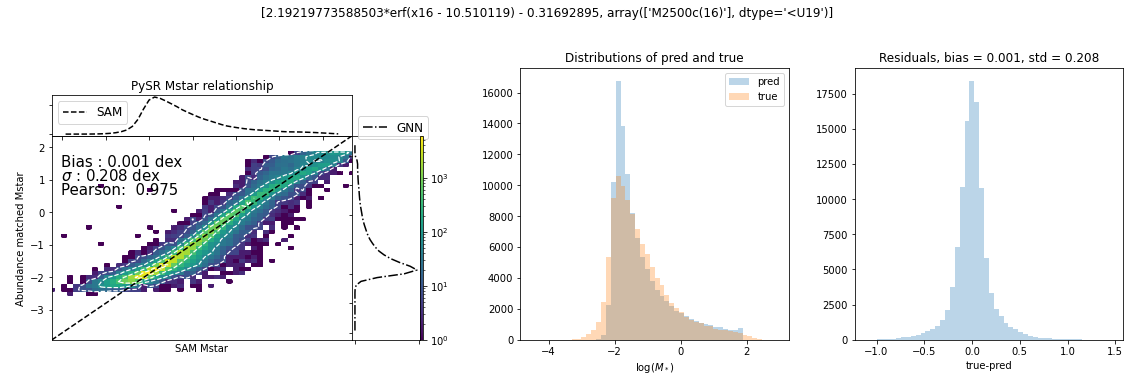

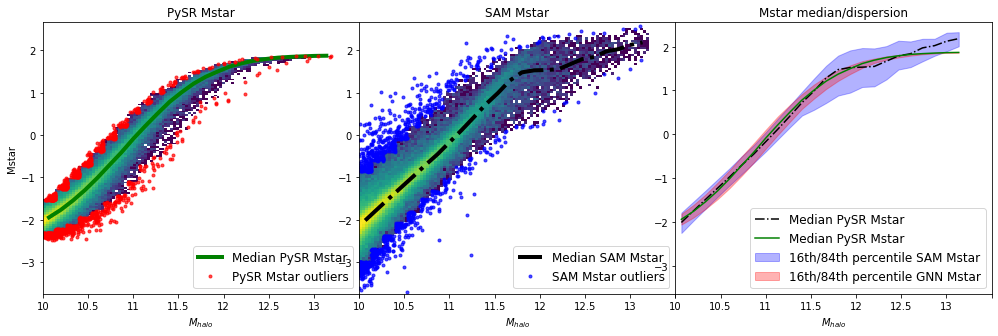

In [23]:
for idx in eqndf.sort_values('fom').index[:5]:
    tmp = f'figs/{tcols[target]}/{files[f][:6]}_eq{idx}_tmp/'
    if not osp.exists(tmp):
        os.mkdir(tmp)

    pred = eqnlam[idx](xs)
    streq = eqns[idx]
    fig1 = plot1(ys[:,target],pred, streq, eqndf.iloc[idx]['vars'])
    fig1.savefig(osp.join(tmp,'fig1.png'), bbox_inches='tight', dpi=100)

    figmh, _, _ =mh_ms(ys[:,target], pred, xs[:,1], fill=1)
    figmh.savefig(osp.join(tmp,'fig2.png'), dpi=100)
    
    rowdf = pd.DataFrame(eqndf.iloc[idx]).T
    rowdf1 = rowdf[rowdf.columns[:6]]
    rowdf2 = rowdf[rowdf.columns[6:]]
    dfi.export(rowdf1, osp.join(tmp,'dfrow1.png'), table_conversion = 'matplotlib')
    dfi.export(rowdf2, osp.join(tmp,'dfrow2.png'), table_conversion = 'matplotlib')
    imgs, imgs_comb, imgs_stack = combine_images(tmp)
    shutil.rmtree(tmp)

In [17]:
s = np.asarray(imgs[0]).shape[1]
shape = np.asarray(imgs[2]).shape[1]
p = (shape-s)//2
padded_im = np.pad(np.asarray(imgs[0]), ((0,0),(p, p), (0,0)), 'constant', constant_values=((0, 0), (0, 0), (0,0)))

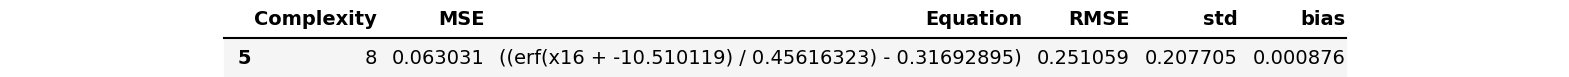

In [18]:
Image.fromarray(padded_im)

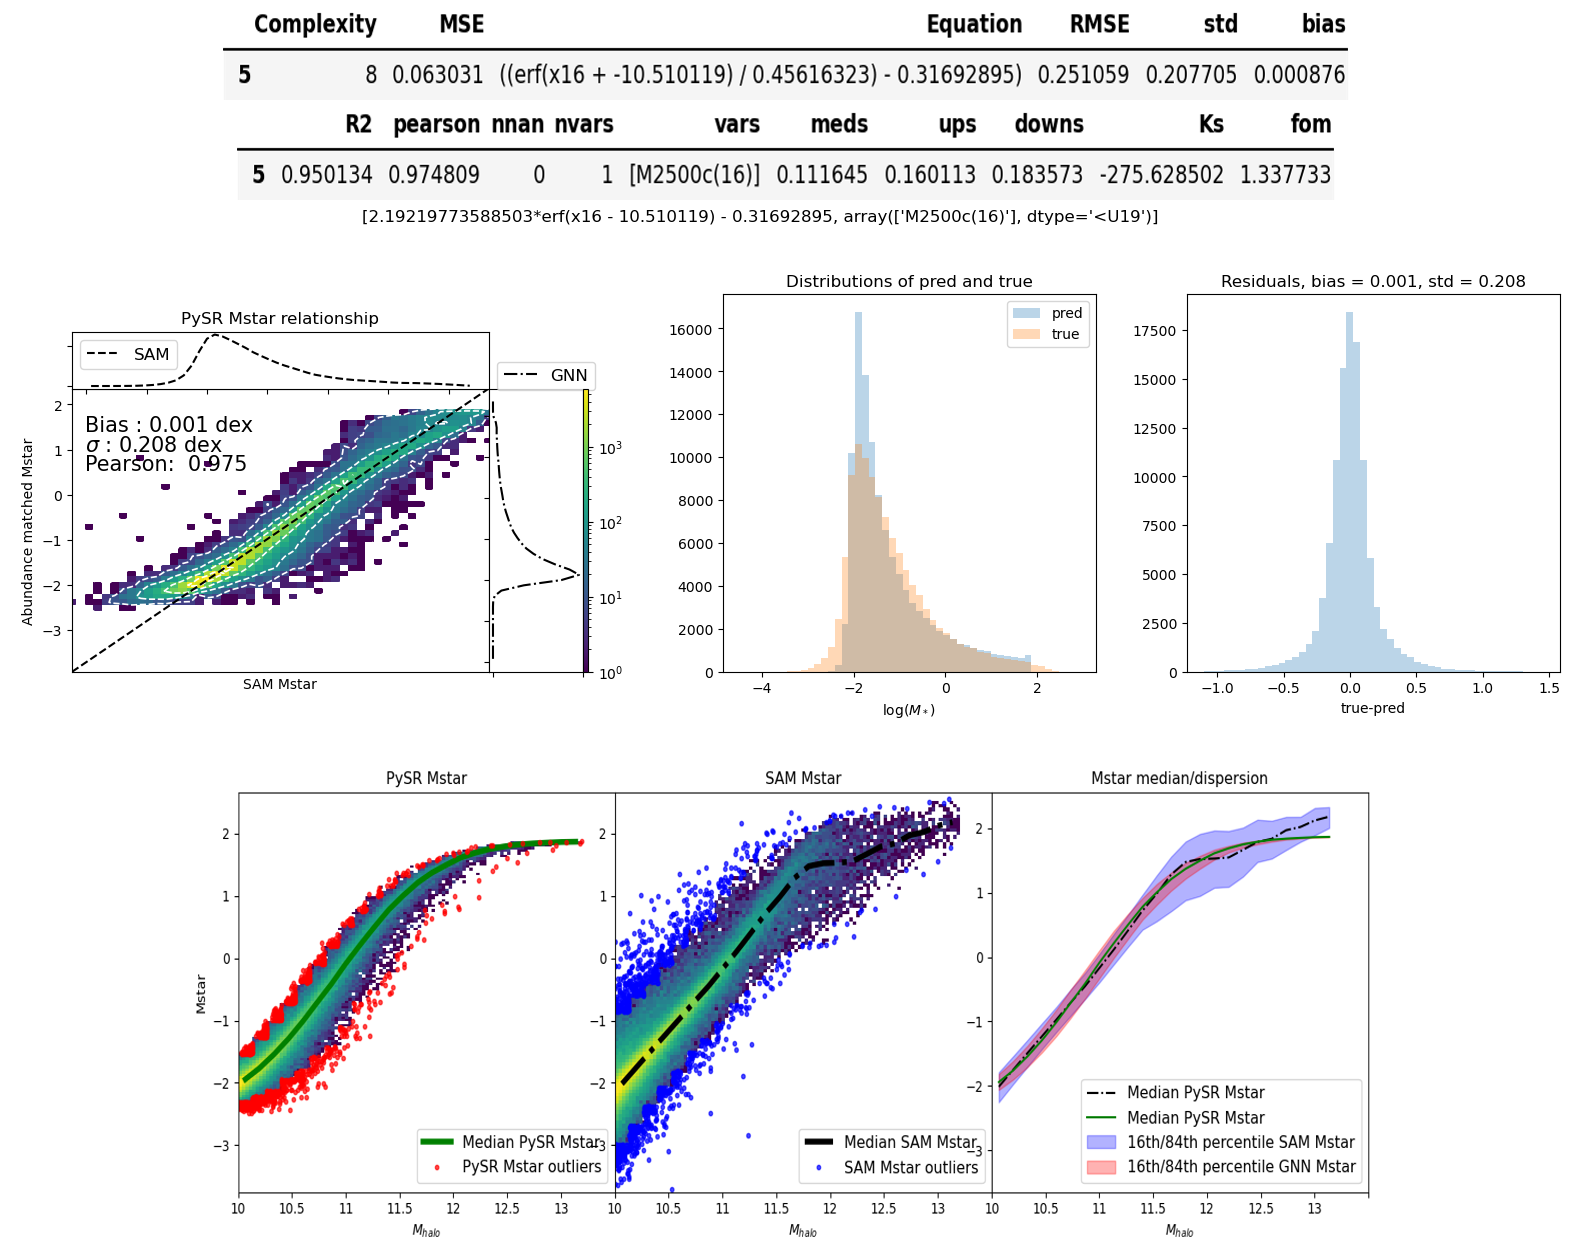

In [19]:
imgs_comb

In [15]:
idx=12
rowdf = pd.DataFrame(eqndf.iloc[idx]).T
rowdf1 = rowdf[rowdf.columns[:6]]
# rowdf1.style.set_properties(subset=['Equation'], **{'width': '500px'})
rowdf2 = rowdf[rowdf.columns[6:]]
rowdf2

,R2,pearson,nnan,nvars,vars,meds,ups,downs,Ks,fom
12,0.956684,0.978646,0,3,"[scale_of_last_MM(5), vmax(6), Tidal_Force(10)]",0.079537,0.147923,0.164724,-137.183922,1.485703


In [17]:
rowdf1

,Complexity,MSE,Equation,RMSE,std,bias
12,15,0.056985,((tanh(log_abs(cube(log10_abs(x6 + x10) + -0.9426591))) * 2.4194505) + (x5 * -0.22084601)),0.238716,0.191449,-0.028673


In [16]:
rowdf = pd.DataFrame(eqndf.iloc[idx]).T
rowdf1 = rowdf[rowdf.columns[:6]]
rowdf2 = rowdf[rowdf.columns[6:]]
dfi.export(rowdf1, f'figs/{tmp}/dfrow1.png', table_conversion = 'matplotlib')
dfi.export(rowdf2, f'figs/{tmp}/dfrow2.png', table_conversion = 'matplotlib')

In [119]:
idx=15
mstar_pred = eqnlam[idx](xs)+9
mstar_ys = ys[:,0]+9
biases, spreads = med_spread(mstar_ys, mstar_pred, xs[:,1])
ybias, predbias = biases
yspread, predspread = spreads
med = np.std(ybias-predbias)
down, up = np.std(yspread - predspread, axis=0)
ks = ks_2samp(mstar_ys, mstar_pred).pvalue
med, down, up, ks

(0.07896788987804439,
 0.1696796105509935,
 0.1467541927596239,
 1.0900136812615227e-110)

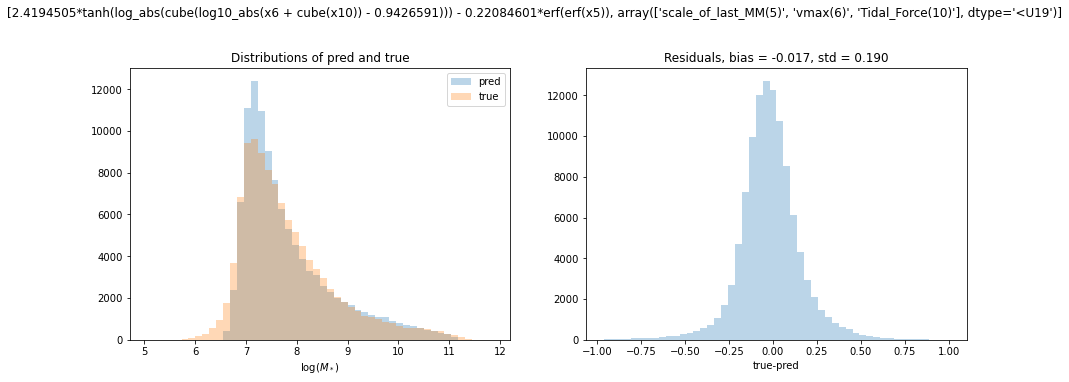

In [120]:
#check distributions
streq = eqns[idx]
fig1 = visual_dist(mstar_ys,mstar_pred, streq)

/tmp/ipykernel_30909/2981231555.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_30909/2981231555.py:125: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\
/tmp/ipykernel_30909/2981231555.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(xticklabels=[10,10.5,11,11.5,12,12.5,13],\


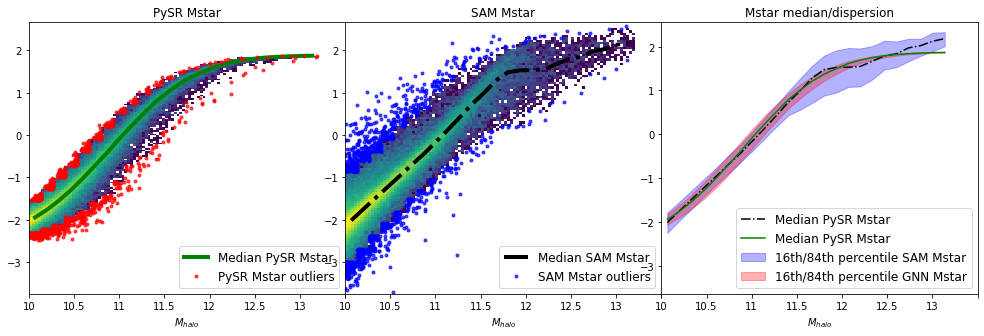

In [121]:
figmh, _, _ =mh_ms(ys[:,target], pred, xs[:,1], fill=1)
# fig.savefig(f'figs/MH_{tcols[target]}_{files[f][:5]}.png')

In [122]:
# def combine_images(path):
# list_im = ['Test1.jpg', 'Test2.jpg', 'Test3.jpg']
# imgs    = [ Image.open(i) for i in list_im ]
# # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
# min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
# imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

# # save that beautiful picture
# imgs_comb = Image.fromarray( imgs_comb)
# imgs_comb.save( 'Trifecta.jpg' )    

# # for a vertical stacking it is simple: use vstack
# imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
# imgs_comb = Image.fromarray( imgs_comb)
# imgs_comb.save( 'Trifecta_vertical.jpg')

In [123]:
# import dataframe_image as dfi

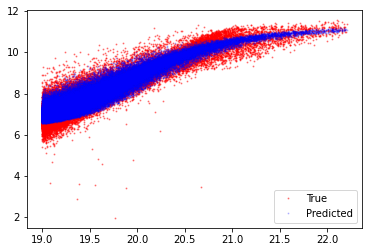

In [124]:
#check M_halo
Mh = xs[:,1]+9 #standard scaled so not quite the usual
plt.plot(Mh, mstar_ys, 'ro', ms=1, alpha=0.4, label='True');
plt.plot(Mh, mstar_pred, 'bo', ms=1, alpha=0.2,label='Predicted');
plt.legend()

In [104]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(ys, pred):
    fig, ax = plt.subplots(figsize=(8, 6))
#     ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets = [r"$M_{*}$"]
    
    targ = tcols[target]
    ys = ys
    pred = pred
    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.1, 0.67
    bottom, height = 0.0, 0.75
    bottom_h = bottom +height
    left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.01, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

    # start with a rectangular Figure
    ax.set_axis_off()
    # axCbar = plt.axes(rect_Cbar)
    axHist = ax.inset_axes(rect_scatter)
    axHistx = ax.inset_axes(rect_histx)
    axHisty = ax.inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.005
    n_contour=4
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white', linestyles='dashed', linewidths=1.2)
    axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
    if i==0:
        axHist.set(xlabel=f'SAM {targ}',ylabel=f'GNN {targ}', xticks=[5,6,7,8,9,10,11])
    else:
        axHist.set(xlabel=f'SAM {targ}',ylabel=f'Abundance matched {targ}', xticks=[5,6,7,8,9,10,11])
    if i==0:
        axHist.legend(loc='lower right', fontsize=14)


    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'

    #calculate metrics
    pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
    r2=r2_score(ys,pred)
    rho = np.corrcoef(ys,pred)[0,1]
    print(np.std(ys-pred),np.mean(ys-pred), pct, r2, rho)

    xt=0.03
    yt=0.85
    dy=0.07
    font = {'weight': 'normal',
        'size': 15}

    axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
    axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys, 0.1)
    pred_kde = stats.gaussian_kde(pred, 0.1)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
    axHistx.legend(loc='upper left',fontsize=12)
    axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.125), fontsize=12)

    axHistx.set(title=f'PySR {targ} relationship')

#         axHistx.set_xlim(axHist.get_xlim())
#         axHisty.set_ylim(axHist.get_ylim())

    divider = make_axes_locatable(axHisty)
    cax = divider.append_axes("right", size="5%", pad=0.0)
    divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

    # Plot vertical colorbar
    plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

0.19038015746313847 -0.01734643113873724 0.8173432753383043 0.9577585469286275 0.9788795633411689


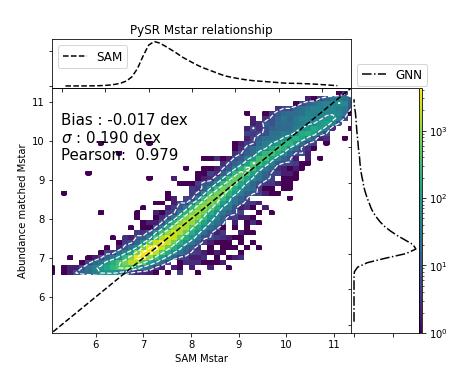

In [105]:
fig = plot(mstar_ys, mstar_pred)

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
0.20770509626293618 0.0008757586933228689 0.8115069501979195 0.9501337245894288 0.9748094843788644


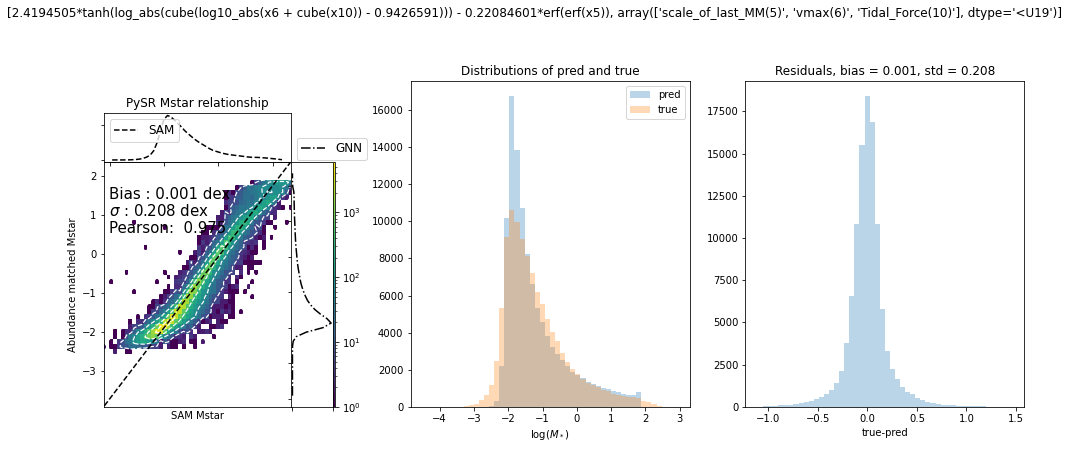

In [125]:
fig = plot1(ys[:,target], pred, streq, eqndf['vars'][idx])